# HSV

In [3]:
from ipynb.fs.full.general_functions import *

def cellHSVMask(img, from_color=(0,170,0),to_color=(20,255,220)):
#def cellHSVMask(img, from_color=(0,80,0),to_color=(20,255,255)):
    img = equalize_color_image(img)
    
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    mask = cv2.inRange(hsv, from_color, to_color)
    return mask

# img = get_image(PATH,mode=1)
# mask = cellHSVMask(img)
# plt.imshow(mask)
# plt.show()

2.4.1
2.4.0


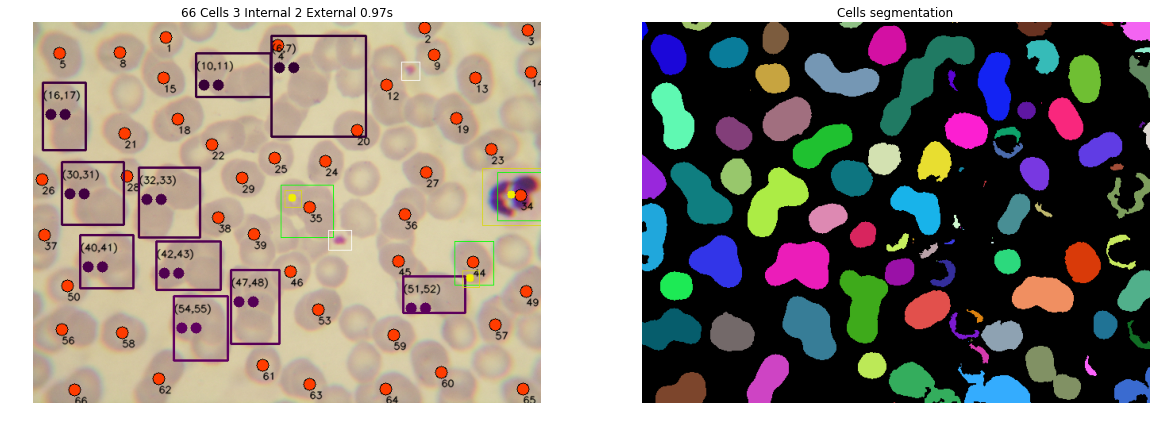

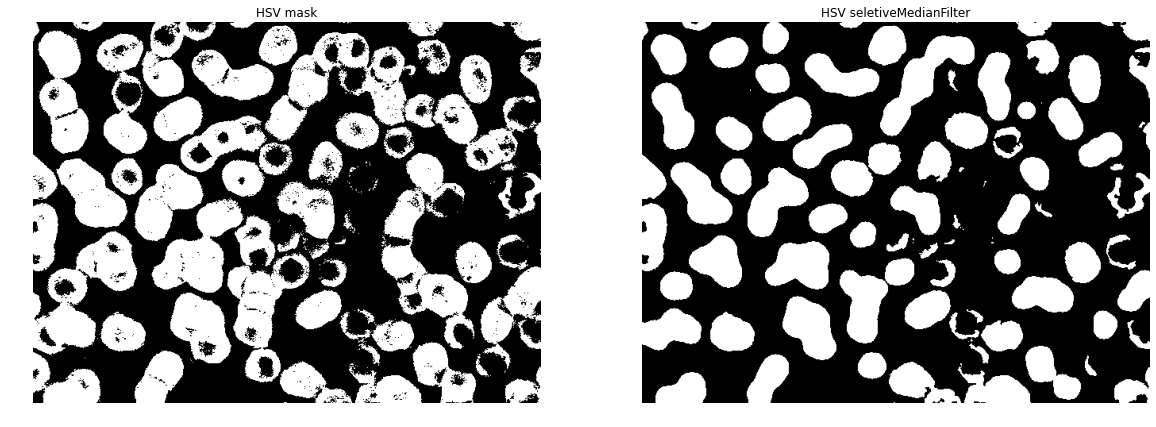

In [7]:

# def seletiveMedianFilter(img, kernel_size):
        
#     new_img = img.copy()
#     divided = floor(kernel_size/2)
    
#     for i in range(divided,img.shape[0]-divided,1):
#         for j in range(divided,img.shape[1]-divided,1):
#             space = img[i-divided:i+divided+1,j-divided:j+divided+1]
#             if np.sum(space) == 0:
#                 new_img[i,j] = np.median(space)
            
#     return new_img


def mergeCellsParts(mask):
    
    mask = mask.copy()
    labeled_img_rgb, numLabels, labels, stats, centroids = connected_components(mask)


    for i in range(1, numLabels):
        x = stats[i, cv2.CC_STAT_LEFT]
        y = stats[i, cv2.CC_STAT_TOP]
        w = stats[i, cv2.CC_STAT_WIDTH]
        h = stats[i, cv2.CC_STAT_HEIGHT]
        area = stats[i, cv2.CC_STAT_AREA]
        (cX, cY) = centroids[i]

        cutY = y - 1 if y > 0 else y
        cutX = x - 1 if x > 0 else x
        cutXW = x+w+1
        cutYH = y+h+1            
            
        cut = mask[cutY:cutYH, cutX:cutXW]
        
        
        if 50 < area < MAX_CELL_AREA:
            thresh_filled = cut
                
            contours, hierarchy = cv2.findContours(thresh_filled, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
            hull = []
            for y in range(len(contours)):
                hull.append(cv2.convexHull(contours[y], False))    
            cv2.drawContours(thresh_filled, hull, -1, 255, 1, 8)
            
            contours, hierarchy = cv2.findContours(thresh_filled, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for i in range(len(contours)):
                cv2.drawContours(thresh_filled, contours, i, 255, -1, cv2.LINE_8, hierarchy, 0)
            
        elif MAX_CELL_AREA < area:
            
            #preenche
            contours, hierarchy = cv2.findContours(cut, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for i in range(len(contours)):
                cv2.drawContours(cut, contours, i, 255, -1, cv2.LINE_8, hierarchy, 0)
            
            #erode as bordas
            contours, hierarchy = cv2.findContours(cut, cv2.RETR_TREE, cv2.CHAIN_APPROX_TC89_L1)
            for i in range(len(contours)):
                cv2.drawContours(cut, contours, i, 255, 1, cv2.LINE_8, hierarchy, 0)
            
            
            #nao deixa apagar nas bordas do corte
#             for x in range(cut.shape[0]):
#                 if (cut[x,0] == 100):
#                     cut[x,0] = 255
#                 if (cut[x,cut.shape[1]-1] == 1):
#                     cut[x,cut.shape[1]-1] = 255
#             for y in range(cut.shape[1]):
#                 if (cut[0,y] == 100):
#                     cut[0,y] = 255
#                 if (cut[cut.shape[0]-1,y] == 1):
#                     cut[cut.shape[0]-1,y] = 255
                    
#             cut[cut == 100] = 0
            
            #cut[True] = mergeCellsParts(cut)
            
            #plt.figure(figsize=(10,10))
            #plt.imshow(cut)
            #plt.show()
        
    return mask
            


def hsv_method(path, validation_type, use_median_filter=True, mark_parasites=True):

    start = time.time()

    #read in grayscale
    imgGS = get_image(path=path)
    #read in colors
    img = get_image(path=path,mode=1)

    #otsu adaptative
    cell_mask = cellHSVMask(img)
    
    #hsv parasite mask
    par_mask, par_mask_dilated = hsv_par_mask(img)
    cell_mask_bk = cell_mask.copy()

    if use_median_filter:
        name = "HSV"
        method_ext = "_hsv"
        #cell_mask = seletiveMedianFilter(cell_mask,3)
        cell_mask = cv2.medianBlur(cell_mask, 3)
        #fill holes
        cell_mask = fill_holes(cell_mask)
        #break gorup of cells
        cell_mask = break_big_groups(cell_mask)
    else:
        name = "HSV convex hull"
        method_ext = "_hsv_hull"
        cell_mask = mergeCellsParts(cell_mask)
        cell_mask = erode(cell_mask,3)
        cell_mask = break_big_groups(cell_mask,_erode=5,_dilate=3)

    #colorize the cells
    cell_mask_colored = colorize(cell_mask)

    #mark
    img, cells = mark_cells(img, cell_mask,validation_type=validation_type)
    if mark_parasites:
        img, internal, external = parasites_mark(img, par_mask_dilated, cell_mask)
    else:
        internal, external = 0,0

    end = time.time()

    passTime = "%.2fs" % (end-start)
    #save results
    save_results(path,name,cells,internal,external, passTime, img, method_ext, validation_type)

    return (img, cell_mask_colored, cell_mask_bk, cell_mask), (cells,internal,external,passTime)
    
    
if __name__ == '__main__':
    
    #PATH = "../PHOTOS_MALARIA_VHIR_UPC/fotos_2015_12_01/P_falciparum/Trofozoits/DSCN0083.JPG"
    #PATH = "../blood_samples/samples/blood_smear_2.JPG"
    #PATH = "../blood_samples/samples/blood_smear_1.JPG"
    PATH = "../blood_samples/samples/blood_smear_8.JPG"
    #PATH = "../blood_samples/samples/blood_smear_14.JPG"

    images, stats = hsv_method(PATH, NO_VALIDATION)
    img, cell_mask_colored, cell_mask_bk, cell_mask = images
    cells,internal,external,passTime = stats

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))    

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask_colored, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))

    ax[0].imshow(cell_mask_bk, cmap='gray')
    ax[0].set_title("HSV mask")
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("HSV seletiveMedianFilter")
    plt.show()


# HSV Convex Hull

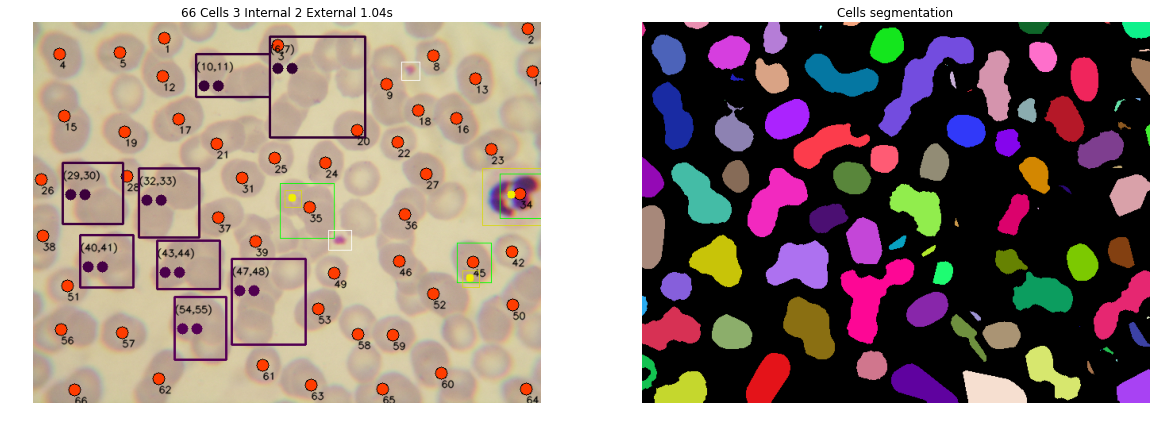

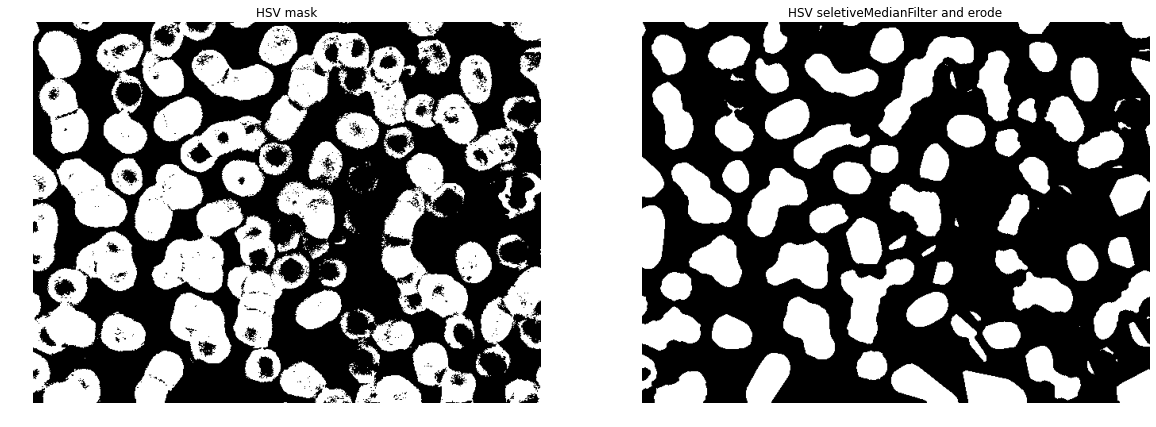

In [8]:
if __name__ == '__main__':
    images, stats = hsv_method(PATH, NO_VALIDATION, use_median_filter=False)

    img, cell_mask_colored, cell_mask_bk, cell_mask = images
    cells,internal,external,passTime = stats

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))    

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title("%d Cells %d Internal %d External %s" %(cells,internal,external, passTime))
    ax[1].imshow(cell_mask_colored, cmap='gray')
    ax[1].set_title("Cells segmentation")
    plt.show()

    fig, ax = plt.subplots(ncols=2, figsize=(20, 20))

    ax[0].imshow(cell_mask_bk, cmap='gray')
    ax[0].set_title("HSV mask")
    ax[1].imshow(cell_mask, cmap='gray')
    ax[1].set_title("HSV seletiveMedianFilter and erode")
    plt.show()